In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score, make_scorer, mean_squared_error, median_absolute_error, mean_absolute_error
from xgboost import XGBRegressor
import xgboost as xgb

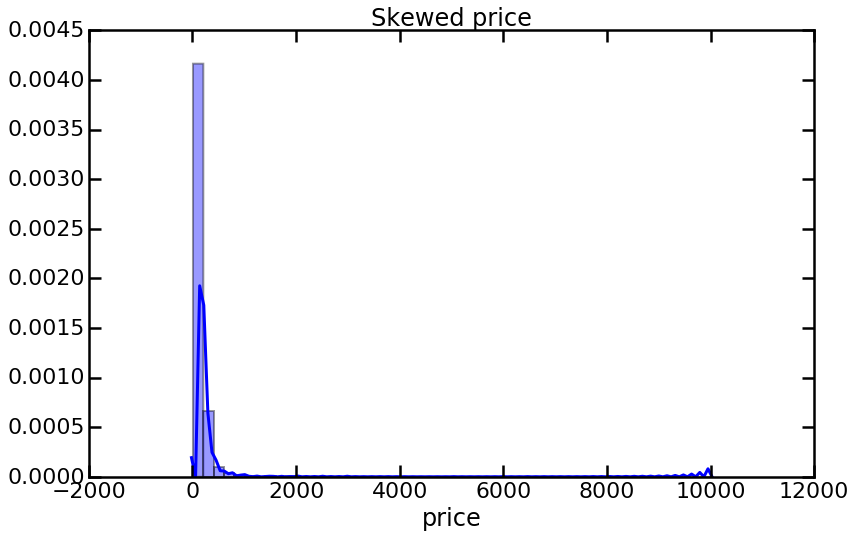

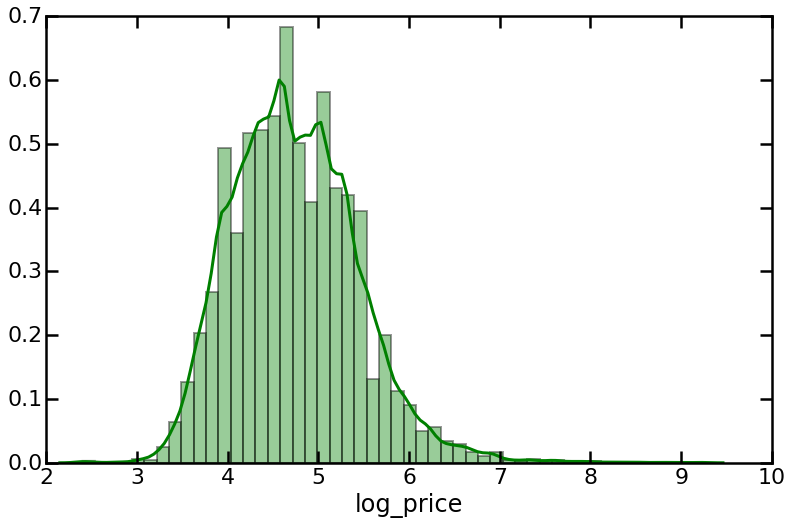

In [3]:
# DATA CLEANING


# Load the dataset
dataset = pd.read_csv('data/AB_NYC_2019.csv')

# Drop unwanted columns
dataset.drop('id', axis=1, inplace=True)
dataset.drop('name', axis=1, inplace=True)
dataset.drop('host_id', axis=1, inplace=True)
dataset.drop('host_name', axis=1, inplace=True)
dataset.drop('number_of_reviews', axis=1, inplace=True)
dataset.drop('last_review', axis=1, inplace=True)
dataset.drop('reviews_per_month', axis=1, inplace=True)
# dataset.drop('latitude', axis=1, inplace=True)
# dataset.drop('longitude', axis=1, inplace=True)

# Remove price = 0
dataset = dataset[dataset.price > 0].copy()#[dataset.price < 500]

# Standardize ratio attributes
dataset[['latitude', 'longitude', 'minimum_nights', 'calculated_host_listings_count', 'availability_365']] = StandardScaler().fit_transform(dataset[['latitude', 'longitude','minimum_nights', 'calculated_host_listings_count', 'availability_365']])

# Log price
dataset['log_price'] = np.log1p(dataset['price'])

# One hot encoding for the categorical features
neighbourhood_group_dummies = pd.get_dummies(dataset['neighbourhood_group'], prefix="is_group")
room_type_dummies = pd.get_dummies(dataset['room_type'], prefix="is_room")
neighbourhood_dummies = pd.get_dummies(dataset['neighbourhood'], prefix="is_neighbourhood")
preprocessed_dataset = pd.concat([dataset[['minimum_nights','calculated_host_listings_count',
       'availability_365']], room_type_dummies, neighbourhood_group_dummies, neighbourhood_dummies, dataset[['price', 'log_price']]], axis=1)

sb.set_context(context='poster')
plt.figure(figsize=(13, 8))
# plots
sb.distplot(preprocessed_dataset['price'], color='blue')
plt.title('Skewed price')
plt.show()

plt.figure(figsize=(13, 8))
sb.distplot(preprocessed_dataset['log_price'], color='green')
plt.show()

In [91]:
print('Total records:', preprocessed_dataset['price'].count())
print('Max price:', preprocessed_dataset['price'].max())
print('Min price:', preprocessed_dataset['price'].min())
print('% of listings with prices above 500:', preprocessed_dataset[preprocessed_dataset.price > 500]['price'].count() * 100 / preprocessed_dataset['price'].count())

Total records: 48884
Max price: 10000
Min price: 10
% of listings with prices above 500: 2.135668112265772


In [4]:
# DIMENSIONALILTY REDUCTION

# Principle Component Analysis
X = preprocessed_dataset.copy().drop('price', axis=1).drop('log_price', axis=1)
X.reset_index(drop=True)
y = preprocessed_dataset['log_price']

print(X.shape, y.shape)
pca = PCA()
pca.fit(X)

cutoff_variance = 0.98 # 0.95
cutoff = 0
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
for i in range(len(cumulative_variance)):
    if cumulative_variance[i] > cutoff_variance:
        cutoff = i
        break
        
print('cutoff =', cutoff)

pca = PCA(n_components=cutoff)
pcaX = pca.fit_transform(X)
pcaX.shape

# get the training and testing sets (PCA)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(pcaX, y, test_size=0.2, random_state=100)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(48884, 232) (48884,)
cutoff = 63
(39107, 63) (9777, 63) (39107,) (9777,)


In [132]:
rows = []

train_preds = []
test_preds = []



models = [XGBRegressor(objective='reg:squarederror'), LinearRegression(), RandomForestRegressor(),  Ridge(), Lasso(alpha=1e-4)]
# [XGBRegressor(objective='reg:squarederror', subsample=1.0, colsample_bytree=1.0, eta=0.05,eval_metric='rmse',max_depth=7,min_child_weight=7)]
        
# models = [XGBRegressor(objective='reg:squarederror'), LinearRegression(), Ridge(), Lasso(alpha=1e-4), RandomForestRegressor()]
for model in models:
    
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    train_preds.append(y_train_pred)
    
    y_pred = model.predict(X_test)
    test_preds.append(y_pred)
    
    rows.append([np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred))),
               r2_score(y_test, y_pred),
               median_absolute_error(np.expm1(y_test), np.expm1(y_pred)),
               mean_absolute_error(np.expm1(y_test), np.expm1(y_pred)),
               np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_train_pred))),
               r2_score(y_train, y_train_pred),
               median_absolute_error(np.expm1(y_train), np.expm1(y_train_pred)),
               mean_absolute_error(np.expm1(y_train), np.expm1(y_train_pred))])
#     rows.append([np.sqrt(mean_squared_error(y_test, y_pred)),
#                r2_score(y_test, y_pred),
#                median_absolute_error(y_test, y_pred),
#                mean_absolute_error(y_test, y_pred),
#                np.sqrt(mean_squared_error(y_train, y_train_pred)),
#                r2_score(y_train, y_train_pred),
#                median_absolute_error(y_train, y_train_pred),
#                mean_absolute_error(y_train, y_train_pred)])
    

 /usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning:Series.base is deprecated and will be removed in a future version


In [6]:
# sb.distplot(y_pred_inv, color='green')
# sb.distplot(y_test_inv, color='blue')
# plt.xlim(-100, 500)
# plt.show()

In [133]:
table = pd.DataFrame(rows, columns=['Test RMSE', 'Test R2', 'Test MedianAE', 'Test MeanAE', 'Train RMSE', 'Train R2', 'Train MedianAE', 'Train MeanAE'])
table

,Test RMSE,Test R2,Test MedianAE,Test MeanAE,Train RMSE,Train R2,Train MedianAE,Train MeanAE
0,182.384986,0.565265,25.919136,56.004031,234.530959,0.563564,25.572182,60.187888
1,184.258552,0.538386,26.642650,57.614534,237.913807,0.528178,26.751058,62.283469
2,170.853442,0.529604,26.172285,57.795976,181.911398,0.818278,13.528998,38.105929
3,184.260840,0.538402,26.639277,57.611601,237.921018,0.528177,26.748187,62.281601
4,184.306194,0.538474,26.623735,57.592015,237.984074,0.528033,26.711154,62.260547


####################### TRAINING SET #######################


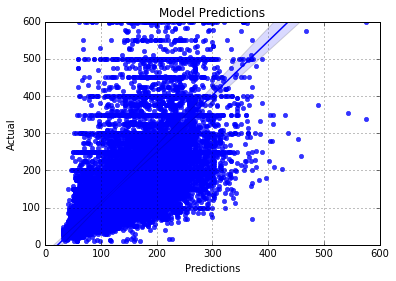

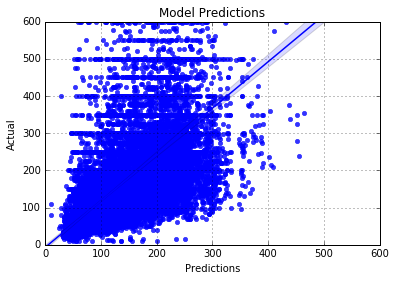

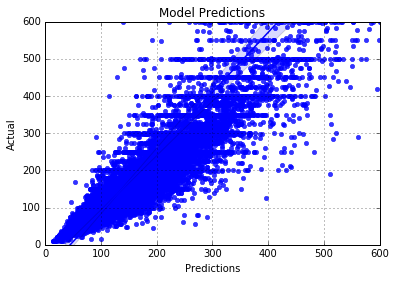

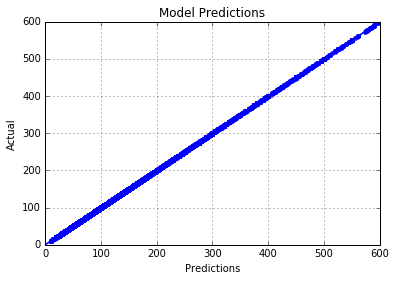

####################### TESTING SET #######################


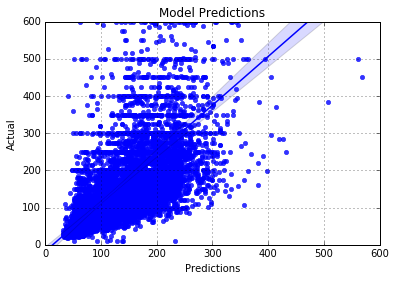

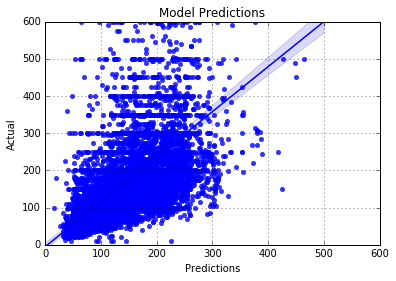

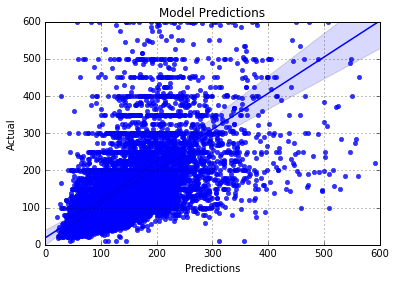

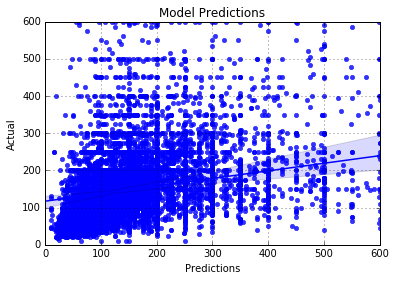

In [35]:
print('####################### TRAINING SET #######################')

for i in range(len(train_preds)):
    
    y_pred_inv = [np.expm1(x) for x in train_preds[i]]
    y_train_inv = [np.expm1(x) for x in y_train]

#     plt.figure(figsize=(16,8))
    sb.regplot(y_pred_inv, y_train_inv)
    plt.ylabel('Actual')
    plt.xlabel('Predictions')
    plt.title("Model Predictions")
    plt.xlim(0, 600)
    plt.ylim(0, 600)
    plt.grid(True)
    plt.show()

print('####################### TESTING SET #######################')

for i in range(len(test_preds)):
    
    y_pred_inv = [np.expm1(x) for x in test_preds[i]]
    y_test_inv = [np.expm1(x) for x in y_test]

#     plt.figure(figsize=(16,8))
    sb.regplot(y_pred_inv, y_test_inv)
    plt.ylabel('Actual')
    plt.xlabel('Predictions')
    plt.title("Model Predictions")
    plt.xlim(0, 600)
    plt.ylim(0, 600)
    plt.grid(True)
    plt.show()

6.214608098422191 2.3978952727983707
11913 11913 11913
2.0712624526971943 -2.6574807800580746


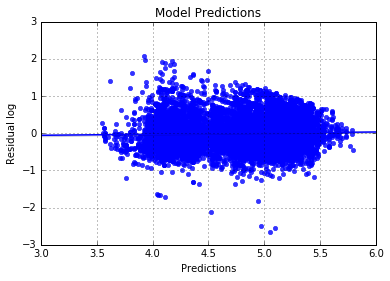

498.99999999999983 10.000000000000002
11913 11913 11913
388.48200988769554 -160.87147521972656


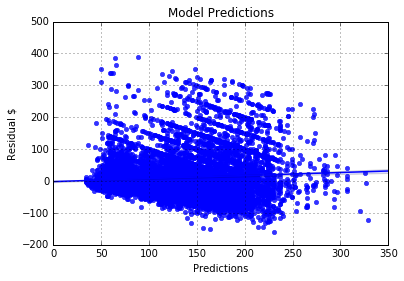

In [109]:
# residual plots

print(y_test.max(), y_test.min())
residual = []
for a, p in zip(y_test, test_preds[0]):
    residual.append(a - p)
print(len(y_test), len(test_preds[0]), len(residual))
print(max(residual), min(residual))
#     plt.figure(figsize=(16,8))
sb.regplot(test_preds[0], residual)
plt.ylabel('Residual log')
plt.xlabel('Predictions')
plt.title("Model Predictions")
# plt.xlim(0, 600)
# plt.ylim(0, 600)
plt.grid(True)
plt.show()


y_pred_inv = [np.expm1(x) for x in test_preds[0]]
y_test_inv = [np.expm1(x) for x in y_test]

print(max(y_test_inv), min(y_test_inv))
residual = []
for a, p in zip(y_test_inv, y_pred_inv):
    residual.append(a - p)
print(len(y_test_inv), len(y_pred_inv), len(residual))
print(max(residual), min(residual))

sb.regplot(y_pred_inv, residual)
plt.ylabel('Residual $')
plt.xlabel('Predictions')
plt.title("Model Predictions")
# plt.xlim(0, 600)
# plt.ylim(0, 600)
plt.grid(True)
plt.show()


In [198]:
scores = {}

def cross_validation_evaluator(model, X, y):
    cv = KFold(n_splits=5, shuffle=True, random_state=45)
    r2 = make_scorer(mean_squared_error)
    cv_score = cross_val_score(model, X, y, cv=cv, scoring=r2)
    print('done!')
    return cv_score.mean()

linearRegressionModel = LinearRegression()
ridgeModel = Ridge()
lassoModel = Lasso(alpha=1e-4)
huberRegressionModel = HuberRegressor()
randomForestModel = RandomForestRegressor()
xgboostModel = XGBRegressor(objective='reg:squarederror')
decisionTreeModel = DecisionTreeRegressor()

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=101)

scores['linear'] = cross_validation_evaluator(linearRegressionModel, X_tr, y_tr)
scores['ridge'] = cross_validation_evaluator(ridgeModel, X_tr, y_tr)
scores['lasso'] = cross_validation_evaluator(lassoModel, X_tr, y_tr)
scores['randomforest'] = cross_validation_evaluator(randomForestModel, X_tr, y_tr)
scores['xgboost'] = cross_validation_evaluator(xgboostModel, X_tr, y_tr)
scores['decisionTree'] = cross_validation_evaluator(decisionTreeModel, X_tr, y_tr)

done!
done!
done!
done!


 /usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning:Series.base is deprecated and will be removed in a future version
 /usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning:Series.base is deprecated and will be removed in a future version
 /usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning:Series.base is deprecated and will be removed in a future version
 /usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning:Series.base is deprecated and will be removed in a future version
 /usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning:Series.base is deprecated and will be removed in a future version


done!
done!


OrderedDict([('xgboost', 0.15093478367807128), ('ridge', 0.15865944914337596), ('linear', 0.1586621694725585), ('lasso', 0.15870531119265097), ('randomforest', 0.16599430755735944), ('decisionTree', 0.24010176411716988)])


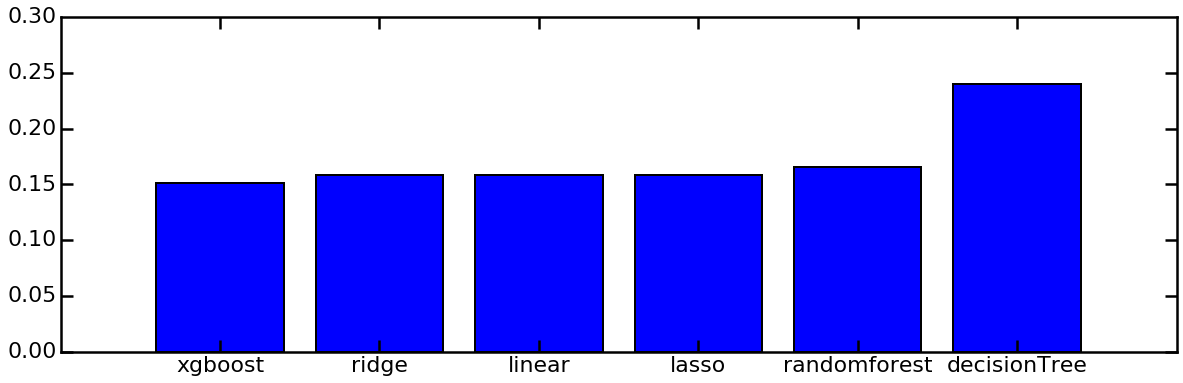

In [203]:
import operator
from collections import OrderedDict
sorted_scores = OrderedDict(sorted(scores.items(), key=operator.itemgetter(1)))

print(sorted_scores)
# plot r2 scores
plt.figure(figsize=(20, 6))
plt.bar(range(len(sorted_scores)), list(sorted_scores.values()), align='center')
plt.xticks(range(len(sorted_scores)), list(sorted_scores.keys()))
plt.ylim(0, 0.3)
plt.show()


In [204]:
xgboostModel = XGBRegressor(objective='reg:squarederror')

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'max_depth':7,
    'min_child_weight':7,
    'eta':0.05,
    'subsample':1,
    'colsample_bytree':1,
    'objective':'reg:squarederror',
    'eval_metric': 'rmse'
}

num_boost_round = 999

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, 'Test')],
    early_stopping_rounds=10
)


 /usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning:Series.base is deprecated and will be removed in a future version


[0]	Test-rmse:4.0249
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:3.82565
[2]	Test-rmse:3.63641
[3]	Test-rmse:3.45678
[4]	Test-rmse:3.28626
[5]	Test-rmse:3.12432
[6]	Test-rmse:2.97061
[7]	Test-rmse:2.82483
[8]	Test-rmse:2.68633
[9]	Test-rmse:2.55493
[10]	Test-rmse:2.43029
[11]	Test-rmse:2.31196
[12]	Test-rmse:2.19972
[13]	Test-rmse:2.09326
[14]	Test-rmse:1.99224
[15]	Test-rmse:1.89644
[16]	Test-rmse:1.80562
[17]	Test-rmse:1.71955
[18]	Test-rmse:1.63797
[19]	Test-rmse:1.56072
[20]	Test-rmse:1.48754
[21]	Test-rmse:1.41828
[22]	Test-rmse:1.35273
[23]	Test-rmse:1.29065
[24]	Test-rmse:1.23199
[25]	Test-rmse:1.1765
[26]	Test-rmse:1.12403
[27]	Test-rmse:1.07452
[28]	Test-rmse:1.02781
[29]	Test-rmse:0.983743
[30]	Test-rmse:0.942164
[31]	Test-rmse:0.90301
[32]	Test-rmse:0.86621
[33]	Test-rmse:0.831598
[34]	Test-rmse:0.79896
[35]	Test-rmse:0.768372
[36]	Test-rmse:0.739648
[37]	Test-rmse:0.712713
[38]	Test-rmse:0.687532
[39]	Test-rmse:0.663945
[40]	Test-rmse:0.641883
[41

In [205]:
rows = []
y_train_pred = model.predict(dtrain)
y_pred = model.predict(dtest)

rows.append([np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred))),
               r2_score(y_test, y_pred),
               median_absolute_error(np.expm1(y_test), np.expm1(y_pred)),
               mean_absolute_error(np.expm1(y_test), np.expm1(y_pred)),
               np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_train_pred))),
               r2_score(y_train, y_train_pred),
               median_absolute_error(np.expm1(y_train), np.expm1(y_train_pred)),
               mean_absolute_error(np.expm1(y_train), np.expm1(y_train_pred))])
rows.append([np.sqrt(mean_squared_error(y_test, y_pred)),
           r2_score(y_test, y_pred),
           median_absolute_error(y_test, y_pred),
           mean_absolute_error(y_test, y_pred),
           np.sqrt(mean_squared_error(y_train, y_train_pred)),
           r2_score(y_train, y_train_pred),
           median_absolute_error(y_train, y_train_pred),
           mean_absolute_error(y_train, y_train_pred)])

In [206]:
table = pd.DataFrame(rows, columns=['Test RMSE', 'Test R2', 'Test MedianAE', 'Test MeanAE', 'Train RMSE', 'Train R2', 'Train MedianAE', 'Train MeanAE'])
table

,Test RMSE,Test R2,Test MedianAE,Test MeanAE,Train RMSE,Train R2,Train MedianAE,Train MeanAE
0,59.835454,0.618015,22.849548,38.267999,57.308338,0.672315,20.991898,36.055174
1,0.378680,0.618015,0.230174,0.289069,0.352936,0.672315,0.216033,0.269686


####################### TESTING SET #######################


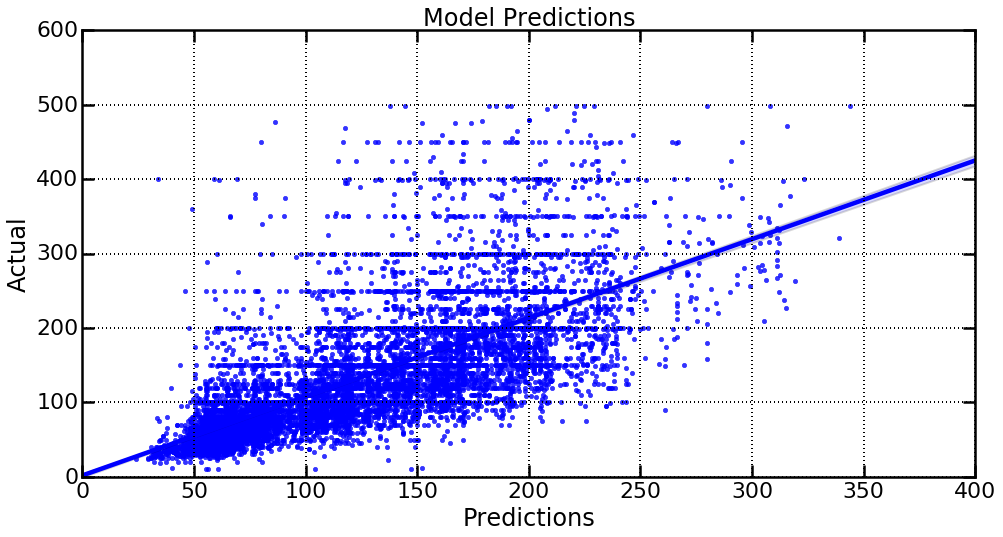

In [208]:
# print('####################### TRAINING SET #######################')

# # for i in range(len(train_preds)):
    
# y_pred_inv = [np.expm1(x) for x in y_train_pred]
# y_train_inv = [np.expm1(x) for x in y_train]

# plt.figure(figsize=(16,8))
# sb.regplot(y_pred_inv, y_train_inv)
# plt.ylabel('Actual')
# plt.xlabel('Predictions')
# plt.title("Model Predictions")
# plt.xlim(0, 1000)
# plt.ylim(0, 2000)
# plt.grid(True)
# plt.show()

print('####################### TESTING SET #######################')

# for i in range(len(test_preds)):
    
y_pred_inv = [np.expm1(x) for x in y_pred]
y_test_inv = [np.expm1(x) for x in y_test]

plt.figure(figsize=(16,8))
sb.regplot(y_pred_inv, y_test_inv)
plt.ylabel('Actual')
plt.xlabel('Predictions')
plt.title("Model Predictions")
plt.xlim(0, 400)
plt.ylim(0, 600)
plt.grid(True)
plt.show()

6.214608098422191 2.3978952727983707
9530 9530 9530
2.442339274978078 -2.515070462028406


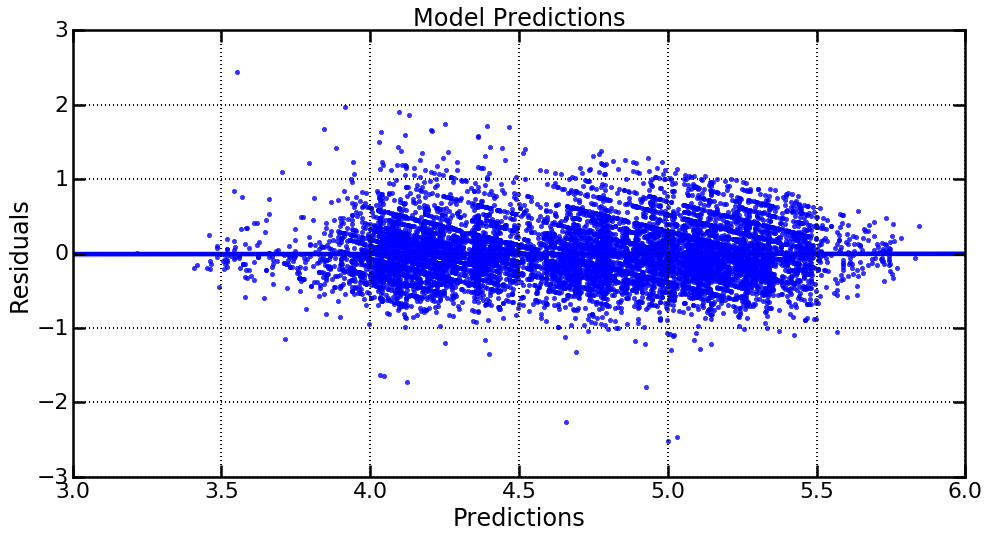

498.99999999999983 10.000000000000002
9530 9530 9530
390.93850708007835 -171.0617370605469


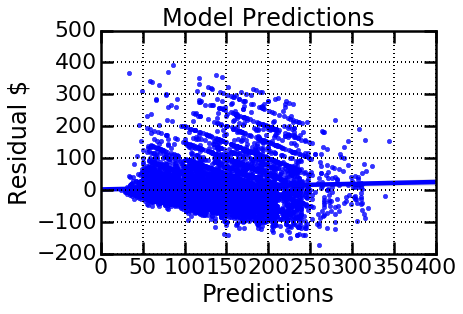

In [209]:
# residual plots

print(y_test.max(), y_test.min())
residual = []
for a, p in zip(y_test, y_pred):
    residual.append(a - p)
print(len(y_test), len(y_pred), len(residual))
print(max(residual), min(residual))

plt.figure(figsize=(16,8))
sb.regplot(y_pred, residual)
plt.ylabel('Residuals')
plt.xlabel('Predictions')
plt.title("Model Predictions")
# plt.xlim(0, 600)
# plt.ylim(0, 600)
plt.grid(True)
plt.show()


y_pred_inv = [np.expm1(x) for x in y_pred]
y_test_inv = [np.expm1(x) for x in y_test]

print(max(y_test_inv), min(y_test_inv))
residual = []
for a, p in zip(y_test_inv, y_pred_inv):
    residual.append(a - p)
print(len(y_test_inv), len(y_pred_inv), len(residual))
print(max(residual), min(residual))

sb.regplot(y_pred_inv, residual)
plt.ylabel('Residual $')
plt.xlabel('Predictions')
plt.title("Model Predictions")
# plt.xlim(0, 600)
# plt.ylim(0, 600)
plt.grid(True)
plt.show()

In [39]:
# PARAMETER TUNING
rows = []
def parameter_tuning(model, params):
    cv = KFold(n_splits=5, shuffle=True, random_state=45)
    r2 = make_scorer(r2_score)
    grid = GridSearchCV(model, params, cv=cv,scoring=r2)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    best_model.fit(X_train, y_train)
    print(grid.best_params_)
    y_train_pred = best_model.predict(X_train)
    y_pred = best_model.predict(X_test)
    
    rows.append([np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred))),
               r2_score(y_test, y_pred),
               median_absolute_error(np.expm1(y_test), np.expm1(y_pred)),
               mean_absolute_error(np.expm1(y_test), np.expm1(y_pred)),
               np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_train_pred))),
               r2_score(y_train, y_train_pred),
               median_absolute_error(np.expm1(y_train), np.expm1(y_train_pred)),
               mean_absolute_error(np.expm1(y_train), np.expm1(y_train_pred))])

In [48]:
lasso_params = {'alpha':[1e-4, 1e-3, 1e-5, 1e-6]}
# ridge_params = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}
ridge_params = {'alpha':[4, 4.5, 5, 5.5]}
parameter_tuning(lasso, lasso_params)
ridge = Ridge()
parameter_tuning(ridge, ridge_params)

{'alpha': 1e-05}
{'alpha': 5}


In [41]:
table = pd.DataFrame(rows, columns=['Test RMSE', 'Test R2', 'Test MedianAE', 'Test MeanAE', 'Train RMSE', 'Train R2', 'Train MedianAE', 'Train MeanAE'])
table

,Test RMSE,Test R2,Test MedianAE,Test MeanAE,Train RMSE,Train R2,Train MedianAE,Train MeanAE
0,184.249455,0.53845,26.647027,57.597181,237.938026,0.528241,26.755487,62.271387
1,184.257292,0.53850,26.618127,57.589239,237.966491,0.528231,26.750319,62.265205


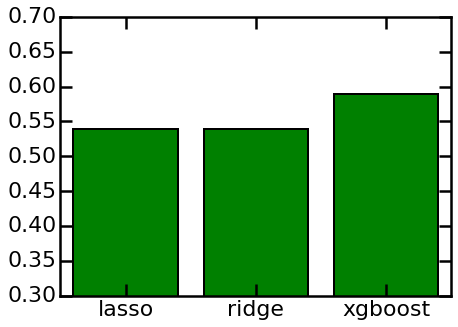

In [57]:
from collections import OrderedDict
tuned_scores = OrderedDict([('lasso', 0.53845), ('ridge', 0.53850), ('xgboost', 0.589132)])
# plot r2 scores
plt.figure(figsize=(7, 5))
plt.bar(range(len(tuned_scores)), list(tuned_scores.values()), align='center', color='green')
plt.xticks(range(len(tuned_scores)), list(tuned_scores.keys()))
plt.ylim(0.3, 0.7)
plt.show()

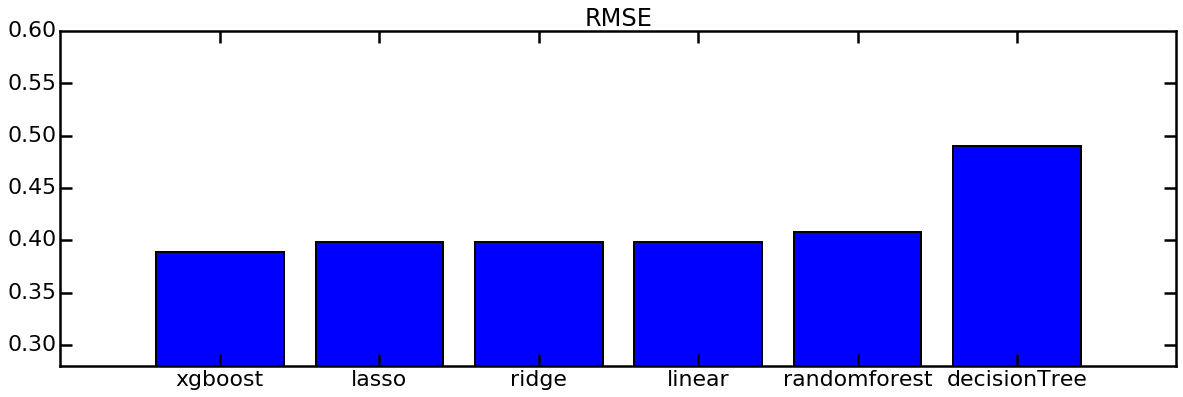

In [18]:
from collections import OrderedDict
import matplotlib.pyplot as plt
from math import sqrt
import seaborn

seaborn.set_context(context='poster')
tuned_scores = OrderedDict([('xgboost', sqrt(0.15093478367807128)), ('lasso', sqrt(0.15870531119265097)), ('ridge', sqrt(0.15865944914337596)), ('linear', sqrt(0.1586621694725585)), ('randomforest', sqrt(0.16599430755735944)), ('decisionTree', sqrt(0.24010176411716988))])

#OrderedDict([('decisionTree', 0.2852324284364912), ('randomforest', 0.5018189764880991), ('linear', 0.5291292008559894), ('lasso', 0.5290159592598538), ('ridge', 0.5291556680646063), ('xgboost', 0.544037520910622)])


# plot r2 scores
plt.figure(figsize=(20, 6))
plt.bar(range(len(tuned_scores)), list(tuned_scores.values()), align='center')
plt.xticks(range(len(tuned_scores)), list(tuned_scores.keys()))
plt.ylim(0.28, 0.6)
plt.title('RMSE')
plt.show()